In [1]:
from pyspark.sql import SparkSession

# Create Spark session
spark = SparkSession.builder \
    .appName("RobotAnalysis") \
    .getOrCreate()

# Set log level to ERROR to hide warnings
spark.sparkContext.setLogLevel("ERROR")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/25 04:34:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# ---------------------------------------------------------------------------------
#  Task 1: Load and Explore the Robot State Data
# ---------------------------------------------------------------------------------

from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, col, count, lag
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import pandas as pd

# Initialize Spark Session
spark = SparkSession.builder.appName("RobotErrorCorrelationAnalysis").getOrCreate()

# Path to your data folder
DATA_PATH = "robots_data/*.parquet"

try:
    # Load all Parquet files
    df = spark.read.parquet(DATA_PATH)
    print(f"Successfully loaded data from {DATA_PATH}")
    print(f"Total records: {df.count()}")

    # Display schema
    print("\n--- Schema ---")
    df.printSchema()

    # Show a few example rows
    print("\n--- Sample Data ---")
    display(df.limit(5).toPandas())

except Exception as e:
    print(f"Error loading data: {e}")





Successfully loaded data from robots_data/*.parquet


Total records: 796013

--- Schema ---
root
 |-- deviceregistryname: string (nullable = true)
 |-- actionstates: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- actionStatus: string (nullable = true)
 |    |    |-- actionDescription: string (nullable = true)
 |    |    |-- actionType: string (nullable = true)
 |    |    |-- actionId: string (nullable = true)
 |    |    |-- resultDescription: string (nullable = true)
 |-- orderid: string (nullable = true)
 |-- velocity: struct (nullable = true)
 |    |-- vX: float (nullable = true)
 |    |-- omega: float (nullable = true)
 |    |-- vY: float (nullable = true)
 |-- agvposition: struct (nullable = true)
 |    |-- y: float (nullable = true)
 |    |-- deviationRange: float (nullable = true)
 |    |-- x: float (nullable = true)
 |    |-- positionInitialized: boolean (nullable = true)
 |    |-- localizationScore: float (nullable = true)
 |    |-- theta: float (nullable = true)
 |    |-- mapDescription: st

,deviceregistryname,actionstates,orderid,velocity,agvposition,waitingforinteractionzonerelease,serialnumber,paused,errors,timestamp,batterystate,driving,operatingmode
0,DEVICE_49e2f6d54d,"[(FINISHED, Automatic zone release, releaseint...",ORDER_c5b8c5cd28,"(-1.9956796169281006, 0.0, 0.025378096848726273)","(274.34661865234375, 0.0, 37.619239807128906, ...",None,SN_9a18015d10,False,[],2112-04-17T05:50:12.918Z,"(False, 85399.0, 3.8259999752044678, 29, 71.0,...",True,AUTOMATIC
1,DEVICE_69b780805d,"[(FINISHED, StraightOnLane, straightonlane, ac...",ORDER_b9e97bce36,"(0.0, 0.0, 0.0)","(292.8985900878906, 0.0, 216.9861602783203, Tr...",None,SN_f90dd30f9a,False,"[(f6dfa1f2-cad7-46a5-8706-35a5ff269e8c, ERR_c1...",2112-04-17T05:50:12.948Z,"(False, 390700.0, 3.5950000286102295, 32, 32.0...",False,AUTOMATIC
2,DEVICE_952d7d4d61,"[(FINISHED, StraightOnLane, straightonlane, ca...",ORDER_783140ec92,"(0.02318260259926319, 0.0044961003586649895, -...","(264.2731018066406, 0.0, 199.16012573242188, T...",None,SN_ced94d441f,False,[],2112-04-17T05:50:12.964Z,"(False, 648600.0, 3.6670000553131104, 33, 54.0...",True,AUTOMATIC
3,DEVICE_f64f449a06,"[(FINISHED, StraightOnLane, straightonlane, 14...",ORDER_748cd1b8c7,"(0.4313473701477051, 0.22030891478061676, -0.2...","(262.16522216796875, 0.0, 216.09129333496094, ...",None,SN_7ea0fcd613,False,[],2112-04-17T05:50:12.989Z,"(False, 661000.0, 3.694000005722046, 33, 55.0,...",True,AUTOMATIC
4,DEVICE_65a92378c3,"[(FINISHED, StraightOnLane, straightonlane, 5a...",ORDER_00b03bc931,"(0.0, 0.0, 0.0)","(263.2684020996094, 0.0, 447.0979309082031, Tr...",None,SN_438c76bdf7,False,"[(72aa5528-aa5d-49b1-aca4-39d655ea48c3, ERR_88...",2112-04-17T05:50:13.067Z,"(False, 85521.0, 3.819000005722046, 28, 71.0, ...",False,AUTOMATIC


In [3]:
from pyspark.sql.functions import col, max as spark_max, min as spark_min, avg as spark_avg

# ---------------------------------------------------------------------------------
#  Task 2: Extract and Categorize All Error Messages
# ---------------------------------------------------------------------------------

# Explode 'errors' array so each error is one row
df_errors = df.withColumn("error_exploded", explode(col("errors"))) \
              .select(
                  col("timestamp"),
                  col("serialnumber"),
                  col("error_exploded.errorType").alias("errorType")
              )

# Count error types
error_counts = df_errors.groupBy("errorType").count().orderBy(col("count").desc())

print("\n--- Error Types Ordered by Occurrence from Top to Bottom ---")
display(error_counts.toPandas())

# Total number of errors
total_errors = df_errors.count()
print(f"\nTotal number of errors: {total_errors}")

# Maximum, minimum, and average occurrence
stats = error_counts.agg(
    spark_max("count").alias("max_count"),
    spark_min("count").alias("min_count"),
    spark_avg("count").alias("avg_count")
).collect()[0]

max_count = stats["max_count"]
min_count = stats["min_count"]
avg_count = stats["avg_count"]

# Identify error types with max and min occurrence
max_error = error_counts.filter(col("count") == max_count).select("errorType").collect()
min_error = error_counts.filter(col("count") == min_count).select("errorType").collect()

max_error_types = [row.errorType for row in max_error]
min_error_types = [row.errorType for row in min_error]

print(f"Maximum occurrence: {max_count} → Error type(s): {max_error_types}")
print(f"Minimum occurrence: {min_count} → Error type(s): {min_error_types}")
print(f"Average occurrence per error type: {avg_count:.2f}")

# Store list of distinct error types for later
ERROR_TYPES = [row.errorType for row in df_errors.select("errorType").distinct().collect()]
print(f"\nTotal distinct error types: {len(ERROR_TYPES)}")



--- Error Types Ordered by Occurrence from Top to Bottom ---


,errorType,count
0,ERR_c100da5a31,404445
1,ERR_32ce10eb44,84262
2,ERR_2a44d8d22a,77473
3,ERR_25c8e1a0a5,56931
4,ERR_fbf129fc50,43964
5,ERR_87499731cb,19276
6,ERR_c85161002d,14946
7,ERR_85d10b03d3,14846
8,ERR_ba69556a87,11053
9,ERR_593110216c,3524



Total number of errors: 753202


Maximum occurrence: 404445 → Error type(s): ['ERR_c100da5a31']
Minimum occurrence: 1 → Error type(s): ['ERR_c62a5795d4']
Average occurrence per error type: 16025.57


[Stage 39:===================>                                      (3 + 6) / 9]


Total distinct error types: 47


In [4]:
# ---------------------------------------------------------------------------------
# Task 3: Calculate Co-Occurrence Probabilities Between Error Types (Optimized)
# ---------------------------------------------------------------------------------
from pyspark.sql.functions import col, collect_set, explode, udf, count as spark_count, lit, size
from pyspark.sql.types import ArrayType, StringType
import pandas as pd

TOP_K_ERRORS = 30   # keep top-K most frequent error types for speed

# --- Step 1: Select top-K error types
top_errors = (df_errors.groupBy("errorType")
                        .count()
                        .orderBy(col("count").desc())
                        .limit(TOP_K_ERRORS))
TOP_ERRORS = [r.errorType for r in top_errors.collect()]

# --- Step 2: Group errors per (timestamp, serialnumber)
df_grouped = df_errors.groupBy("timestamp", "serialnumber") \
                      .agg(collect_set("errorType").alias("error_set"))

# --- Step 3: Filter sets to top-K only
def filter_top(errors):
    return [e for e in errors if e in set(TOP_ERRORS)]
filter_udf = udf(filter_top, ArrayType(StringType()))
df_grouped = df_grouped.withColumn("error_set_top", filter_udf(col("error_set"))) \
                       .filter(size(col("error_set_top")) > 0)

# --- Step 4: Generate unordered pairs within each set
def make_pairs(errors):
    errors = sorted(set(errors))
    return [[errors[i], errors[j]] for i in range(len(errors))
            for j in range(i, len(errors))]
make_pairs_udf = udf(make_pairs, ArrayType(ArrayType(StringType())))

pairs_df = (df_grouped
            .withColumn("pairs", make_pairs_udf(col("error_set_top")))
            .select(explode(col("pairs")).alias("pair")))

pairs_df = pairs_df.withColumn("e1", col("pair")[0]).withColumn("e2", col("pair")[1]).drop("pair")

# --- Step 5: Count pair and single occurrences
pair_counts = pairs_df.groupBy("e1", "e2").agg(spark_count(lit(1)).alias("count")).cache()
single_counts = (df_errors.filter(col("errorType").isin(TOP_ERRORS))
                            .groupBy("errorType")
                            .agg(spark_count(lit(1)).alias("count")))
pair_pd = pair_counts.toPandas()
single_pd = single_counts.toPandas()

# --- Step 6: Build conditional probability matrix P(B | A)
cond_matrix = pd.DataFrame(0.0, index=TOP_ERRORS, columns=TOP_ERRORS)
single_map = dict(zip(single_pd["errorType"], single_pd["count"]))

for _, r in pair_pd.iterrows():
    a, b, c = r["e1"], r["e2"], r["count"]
    if a == b:
        cond_matrix.loc[a, a] = c / single_map.get(a, 1)
    else:
        if single_map.get(a, 0) > 0:
            cond_matrix.loc[a, b] = c / single_map[a]
        if single_map.get(b, 0) > 0:
            cond_matrix.loc[b, a] = c / single_map[b]

print("Co-occurrence probability matrix ready (P(B | A))")
display(cond_matrix.head())


Co-occurrence probability matrix ready (P(B | A))


,ERR_c100da5a31,ERR_32ce10eb44,ERR_2a44d8d22a,ERR_25c8e1a0a5,ERR_fbf129fc50,ERR_87499731cb,ERR_c85161002d,ERR_85d10b03d3,ERR_ba69556a87,ERR_593110216c,...,ERR_ac95dd1bbe,ERR_9c25d809ed,ERR_825403600b,ERR_473cb17b82,ERR_2741e46e0f,ERR_e0fd78ecfd,ERR_03c035c3a1,ERR_a2f88ff3cb,ERR_da352ee84a,ERR_87e62acf13
ERR_c100da5a31,0.999998,0.138842,0.146861,0.062142,0.108220,0.017365,0.000180,0.000749,0.027329,0.006861,...,0.001434,0.001088,0.000000,0.000593,0.00000,0.000452,0.00047,0.000532,0.000482,0.000351
ERR_32ce10eb44,0.666421,1.000000,0.141974,0.247632,0.001507,0.033918,0.000000,0.000000,0.131174,0.001009,...,0.000985,0.001163,0.004569,0.000558,0.00000,0.000000,0.00000,0.000000,0.002362,0.000000
ERR_2a44d8d22a,0.766680,0.154415,1.000000,0.006247,0.567475,0.000000,0.188337,0.191628,0.142669,0.000000,...,0.000000,0.000000,0.004969,0.000013,0.00302,0.000400,0.00284,0.002775,0.002517,0.001833
ERR_25c8e1a0a5,0.441464,0.366514,0.008502,1.000000,0.000000,0.007816,0.000000,0.000000,0.000000,0.002196,...,0.000527,0.000351,0.006763,0.000105,0.00000,0.000351,0.00000,0.000000,0.000000,0.000000
ERR_fbf129fc50,0.995565,0.002889,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000


In [5]:
# ---------------------------------------------------------------------------------
# Task 4: Time-Series Analysis — Determine if Specific Errors Predict Others
# ---------------------------------------------------------------------------------
from pyspark.sql.window import Window
from pyspark.sql.functions import lead, explode

# --- Step 1: Order rows by timestamp per robot
w = Window.partitionBy("serialnumber").orderBy("timestamp")

# --- Step 2: Add next-timestamp error set
df_next = df_grouped.withColumn("next_error_set", lead(col("error_set_top"), 1).over(w)) \
                    .filter(col("next_error_set").isNotNull())

# --- Step 3: Create cross-pairs between current and next sets (a_now, b_next)
def current_next_pairs(curr, nxt):
    if not curr or not nxt:
        return []
    pairs = []
    for a in curr:
        for b in nxt:
            pairs.append([a, b])
    return pairs
current_next_udf = udf(current_next_pairs, ArrayType(ArrayType(StringType())))

pairs_ts = (df_next
            .withColumn("pairs", current_next_udf(col("error_set_top"), col("next_error_set")))
            .select(explode(col("pairs")).alias("pair")))

pairs_ts = pairs_ts.withColumn("a_now", col("pair")[0]).withColumn("b_next", col("pair")[1]).drop("pair")

# --- Step 4: Count predictive pairs and compute P(B_next | A_now)
pred_counts = pairs_ts.groupBy("a_now", "b_next").agg(spark_count(lit(1)).alias("count")).toPandas()
ts_matrix = pd.DataFrame(0.0, index=TOP_ERRORS, columns=TOP_ERRORS)
for _, r in pred_counts.iterrows():
    a, b, c = r["a_now"], r["b_next"], r["count"]
    denom = single_map.get(a, 0)
    if denom > 0:
        ts_matrix.loc[a, b] = c / denom

print(" Time-series predictive matrix ready (P(B_next | A_now))")
display(ts_matrix.head())


 Time-series predictive matrix ready (P(B_next | A_now))


,ERR_c100da5a31,ERR_32ce10eb44,ERR_2a44d8d22a,ERR_25c8e1a0a5,ERR_fbf129fc50,ERR_87499731cb,ERR_c85161002d,ERR_85d10b03d3,ERR_ba69556a87,ERR_593110216c,...,ERR_ac95dd1bbe,ERR_9c25d809ed,ERR_825403600b,ERR_473cb17b82,ERR_2741e46e0f,ERR_e0fd78ecfd,ERR_03c035c3a1,ERR_a2f88ff3cb,ERR_da352ee84a,ERR_87e62acf13
ERR_c100da5a31,0.997854,0.138840,0.146848,0.062080,0.108210,0.017372,0.000180,0.000747,0.027326,0.006861,...,0.001434,0.001090,0.000000,0.000593,0.000000,0.000452,0.000470,0.000532,0.000485,0.000351
ERR_32ce10eb44,0.666374,0.999288,0.141962,0.247632,0.001507,0.033894,0.000000,0.000000,0.131162,0.001009,...,0.000985,0.001163,0.004569,0.000582,0.000000,0.000000,0.000000,0.000000,0.002362,0.000000
ERR_2a44d8d22a,0.766719,0.154415,0.999316,0.006260,0.567359,0.000039,0.188324,0.191589,0.142656,0.000000,...,0.000000,0.000000,0.004957,0.000013,0.003007,0.000413,0.002801,0.002749,0.002530,0.001833
ERR_25c8e1a0a5,0.443133,0.366567,0.008519,0.995205,0.000000,0.007939,0.000000,0.000000,0.000000,0.002213,...,0.000545,0.000351,0.006763,0.000667,0.000000,0.000334,0.000000,0.000000,0.000000,0.000000
ERR_fbf129fc50,0.995587,0.002889,0.999795,0.000000,0.999795,0.000023,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


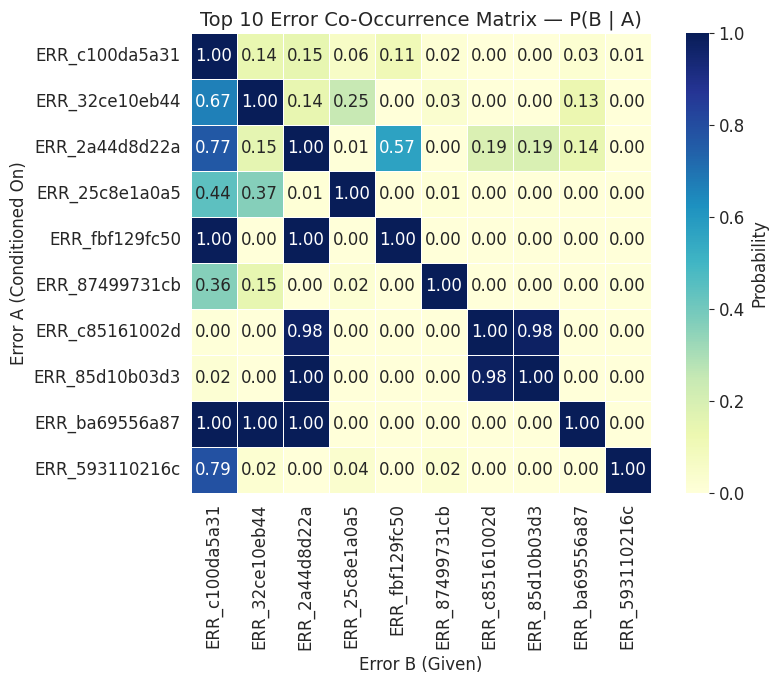

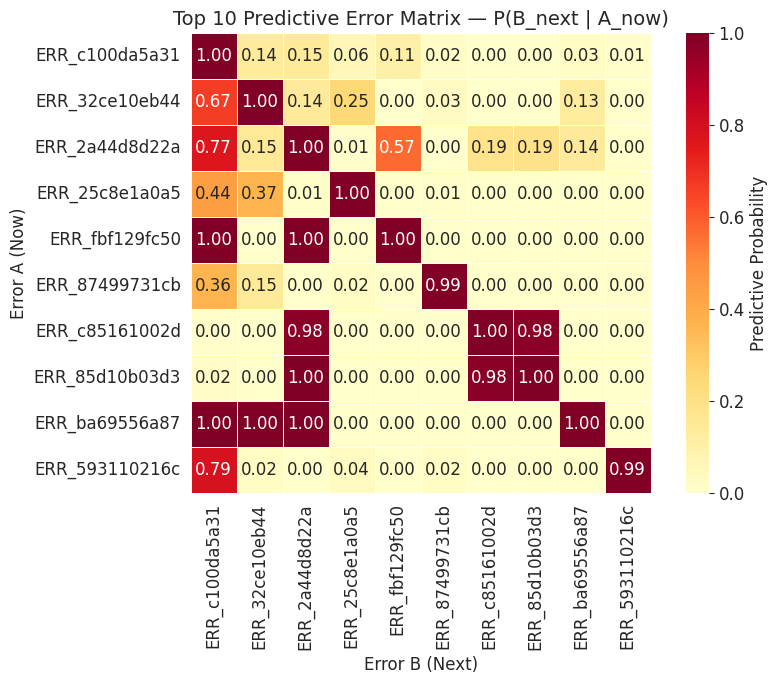

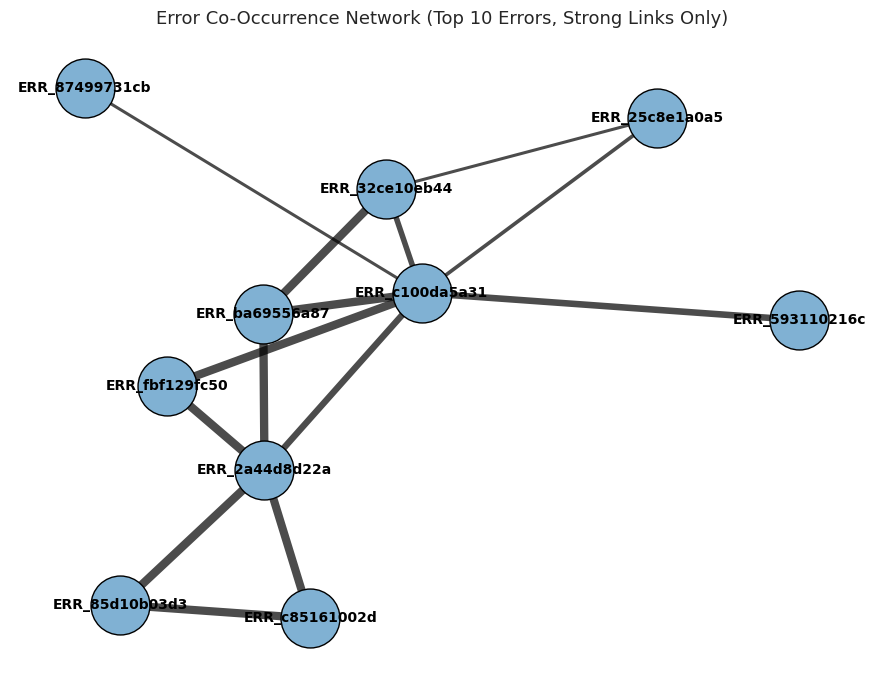

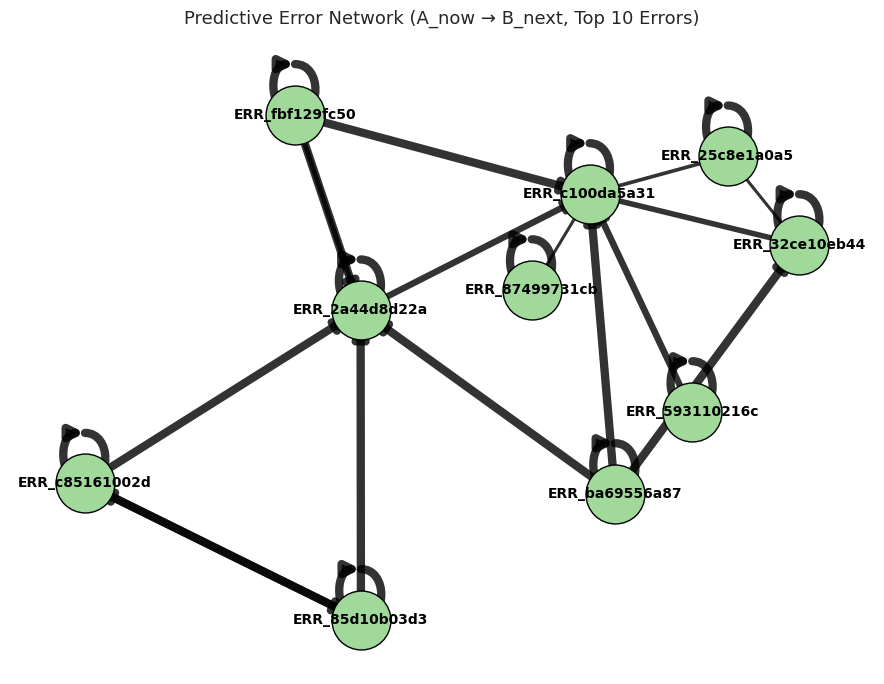

In [6]:
# ---------------------------------------------------------------------------------
# Task 5: Visualize Error Relationships (Top 10 Most Frequent Errors)
# ---------------------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# --- STYLE SETTINGS ---
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12, 'axes.titlesize': 14, 'axes.labelsize': 12})

# ---------------------------------------------------------------------------------
# Step 0: Focus on Top 10 Most Frequent Errors
# ---------------------------------------------------------------------------------
top_n = 10
top_errors = TOP_ERRORS[:top_n]  # select only top 10
cond_sub = cond_matrix.loc[top_errors, top_errors]
ts_sub = ts_matrix.loc[top_errors, top_errors]

# ---------------------------------------------------------------------------------
# 1. Co-Occurrence Heatmap (P(B | A))
# ---------------------------------------------------------------------------------
plt.figure(figsize=(9, 7))
sns.heatmap(cond_sub, cmap="YlGnBu", annot=True, fmt=".2f",
            linewidths=0.5, square=True, cbar_kws={'label': 'Probability'})
plt.title(f"Top {top_n} Error Co-Occurrence Matrix — P(B | A)")
plt.xlabel("Error B (Given)")
plt.ylabel("Error A (Conditioned On)")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------------
# 2. Predictive Heatmap (P(B_next | A_now))
# ---------------------------------------------------------------------------------
plt.figure(figsize=(9, 7))
sns.heatmap(ts_sub, cmap="YlOrRd", annot=True, fmt=".2f",
            linewidths=0.5, square=True, cbar_kws={'label': 'Predictive Probability'})
plt.title(f"Top {top_n} Predictive Error Matrix — P(B_next | A_now)")
plt.xlabel("Error B (Next)")
plt.ylabel("Error A (Now)")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------------
# 3. Co-Occurrence Network Graph (Undirected)
# ---------------------------------------------------------------------------------
G = nx.Graph()
threshold = 0.3  # slightly higher threshold for cleaner visualization

for a in top_errors:
    for b in top_errors:
        if a != b and cond_sub.loc[a, b] > threshold:
            G.add_edge(a, b, weight=cond_sub.loc[a, b])

plt.figure(figsize=(9, 7))
pos = nx.spring_layout(G, seed=42, k=0.7)
edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items()) if len(G.edges) > 0 else ([], [])

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=1800, node_color="#80b1d3", edgecolors="black")

# Draw edges
if edges:
    nx.draw_networkx_edges(G, pos, edgelist=edges, width=np.array(weights)*6, alpha=0.7)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")

plt.title(f"Error Co-Occurrence Network (Top {top_n} Errors, Strong Links Only)", fontsize=13)
plt.axis("off")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------------
# 4. Predictive Network Graph (Directed)
# ---------------------------------------------------------------------------------
G_pred = nx.DiGraph()
for a in top_errors:
    for b in top_errors:
        if ts_sub.loc[a, b] > threshold:
            G_pred.add_edge(a, b, weight=ts_sub.loc[a, b])

plt.figure(figsize=(9, 7))
pos = nx.kamada_kawai_layout(G_pred)
edges, weights = zip(*nx.get_edge_attributes(G_pred, 'weight').items()) if len(G_pred.edges) > 0 else ([], [])

# Draw nodes
nx.draw_networkx_nodes(G_pred, pos, node_color="#a1d99b", node_size=1800, edgecolors="black")

# Draw edges with arrows
if edges:
    nx.draw_networkx_edges(G_pred, pos, edgelist=edges,
                           width=np.array(weights)*6, alpha=0.8,
                           arrowstyle='-|>', arrowsize=18)

# Draw labels
nx.draw_networkx_labels(G_pred, pos, font_size=10, font_weight="bold")

plt.title(f"Predictive Error Network (A_now → B_next, Top {top_n} Errors)", fontsize=13)
plt.axis("off")
plt.tight_layout()
plt.show()



In [7]:
# ---------------------------------------------------------------------------------
# Extra Task 1: EWMA-Based Anomaly Detection (applyInPandas version)
# ---------------------------------------------------------------------------------
import pandas as pd
import numpy as np
from pyspark.sql.functions import array_contains, col

# -----------------------------
# Parameters
# -----------------------------
span = 5          # EWMA span
threshold = 2.0   # anomaly threshold in standard deviations

# -----------------------------
# Step 1: Define function for applyInPandas
# -----------------------------
def detect_ewma_anomalies(pdf):
    """
    Detects anomalies using EWMA for each error type in a robot's time series.

    Args:
        pdf (pd.DataFrame): Pandas DataFrame grouped by robot serialnumber.

    Returns:
        pd.DataFrame: DataFrame with timestamp, serialnumber, errorType, and anomaly flag (0/1).
    """
    pdf = pdf.sort_values("timestamp")
    records = []

    for error in TOP_ERRORS:  # iterate over top error types
        series = pdf[error].fillna(0)

        # Compute EWMA mean and standard deviation
        ewma = series.ewm(span=span, adjust=False).mean()
        ewma_std = series.ewm(span=span, adjust=False).std().fillna(0)

        # Flag anomalies where deviation exceeds threshold
        anomaly_mask = ((series - ewma) > threshold * ewma_std).astype(int)

        for ts, sn, a in zip(pdf['timestamp'], pdf['serialnumber'], anomaly_mask):
            records.append((ts, sn, error, a))

    return pd.DataFrame(records, columns=["timestamp", "serialnumber", "errorType", "anomaly"])

# -----------------------------
# Step 2: Pivot df_grouped to have one column per error (binary 0/1)
# -----------------------------
df_binary = df_grouped
for error in TOP_ERRORS:
    df_binary = df_binary.withColumn(
        error, array_contains(col("error_set_top"), error).cast("int")
    )

# -----------------------------
# Step 3: Apply EWMA per robot using applyInPandas
# -----------------------------
schema = "timestamp string, serialnumber string, errorType string, anomaly int"
df_anomalies = df_binary.groupby("serialnumber").applyInPandas(
    detect_ewma_anomalies, schema=schema
)

# -----------------------------
# Step 4: Preview results
# -----------------------------
df_anomalies.show(100)


+--------------------+-------------+--------------+-------+
|           timestamp| serialnumber|     errorType|anomaly|
+--------------------+-------------+--------------+-------+
|2112-04-17T03:21:...|SN_3121b80fc3|ERR_c100da5a31|      0|
|2112-04-17T03:21:...|SN_3121b80fc3|ERR_c100da5a31|      0|
|2112-04-17T03:21:...|SN_3121b80fc3|ERR_c100da5a31|      0|
|2112-04-17T03:21:...|SN_3121b80fc3|ERR_c100da5a31|      0|
|2112-04-17T03:21:...|SN_3121b80fc3|ERR_c100da5a31|      0|
|2112-04-17T03:21:...|SN_3121b80fc3|ERR_c100da5a31|      0|
|2112-04-17T03:21:...|SN_3121b80fc3|ERR_c100da5a31|      0|
|2112-04-17T03:21:...|SN_3121b80fc3|ERR_c100da5a31|      0|
|2112-04-17T03:21:...|SN_3121b80fc3|ERR_c100da5a31|      0|
|2112-04-17T03:21:...|SN_3121b80fc3|ERR_c100da5a31|      0|
|2112-04-17T03:21:...|SN_3121b80fc3|ERR_c100da5a31|      0|
|2112-04-17T03:21:...|SN_3121b80fc3|ERR_c100da5a31|      0|
|2112-04-17T03:21:...|SN_3121b80fc3|ERR_c100da5a31|      0|
|2112-04-17T03:21:...|SN_3121b80fc3|ERR_

In [8]:
# ---------------------------------------------------------------------------------
# Extra Task 2: Calculate Error Impact on Robot Movement (Fix for agvposition struct)
# ---------------------------------------------------------------------------------
from pyspark.sql.functions import col, mean, count, explode

# --- Step 1: Explode errors ---
df_movement = df.select(
    "timestamp",
    "serialnumber",
    col("velocity.vX").alias("vX"),
    col("velocity.vY").alias("vY"),
    col("velocity.omega").alias("omega"),
    col("agvposition.x").alias("pos_x"),
    col("agvposition.y").alias("pos_y"),
    col("agvposition.theta").alias("theta"),
    col("agvposition.deviationRange").alias("deviationRange"),
    col("agvposition.localizationScore").alias("localizationScore"),
    explode(col("errors")).alias("error_exploded")
).select(
    "timestamp",
    "serialnumber",
    "vX", "vY", "omega",
    "pos_x", "pos_y", "theta", "deviationRange", "localizationScore",
    col("error_exploded.errorType").alias("errorType")
)

# --- Step 2: Filter to top errors ---
df_movement = df_movement.filter(col("errorType").isin(TOP_ERRORS))

# --- Step 3: Aggregate metrics per error ---
error_impact = (
    df_movement.groupBy("errorType")
    .agg(
        mean("vX").alias("avg_vX"),
        mean("vY").alias("avg_vY"),
        mean("omega").alias("avg_omega"),
        mean("pos_x").alias("avg_pos_x"),
        mean("pos_y").alias("avg_pos_y"),
        mean("theta").alias("avg_theta"),
        mean("deviationRange").alias("avg_deviationRange"),
        mean("localizationScore").alias("avg_localizationScore"),
        count("errorType").alias("occurrences")
    )
    .orderBy(col("occurrences").desc())
)

# --- Step 4: Display results ---
print("--- Error Impact on Robot Movement ---")
display(error_impact.toPandas())


--- Error Impact on Robot Movement ---


,errorType,avg_vX,avg_vY,avg_omega,avg_pos_x,avg_pos_y,avg_theta,avg_deviationRange,avg_localizationScore,occurrences
0,ERR_c100da5a31,-1.613802e-03,5.362694e-03,0.000274,214.884982,265.125678,-0.740865,0.0,0.900473,404445
1,ERR_32ce10eb44,2.904097e-04,2.081358e-03,0.002379,206.023316,258.685678,-0.979460,0.0,0.889472,84262
2,ERR_2a44d8d22a,1.609195e-04,-5.041172e-06,-0.000028,276.194704,274.527650,-0.479291,0.0,0.863010,77473
3,ERR_25c8e1a0a5,-2.838682e-02,-2.035926e-01,0.008730,229.382404,267.119261,-0.749356,0.0,0.871068,56931
4,ERR_fbf129fc50,1.426367e-05,1.499217e-04,0.000021,279.765624,287.352757,-1.561526,0.0,0.865885,43964
5,ERR_87499731cb,-1.223308e-02,-1.287088e-01,0.004920,275.769402,264.881020,-0.290855,0.0,0.854375,19276
6,ERR_c85161002d,1.264799e-05,-8.551407e-08,0.000000,372.651426,258.078580,3.022001,0.0,0.832278,14946
7,ERR_85d10b03d3,0.000000e+00,0.000000e+00,0.000000,369.519503,256.877156,3.050534,0.0,0.831509,14846
8,ERR_ba69556a87,0.000000e+00,0.000000e+00,0.000000,191.796916,260.460683,-1.695205,0.0,0.904290,11053
9,ERR_593110216c,-1.825830e-03,1.334773e-02,-0.000605,182.636238,248.700214,-0.100874,0.0,0.882855,3524
